In [51]:
import pandas as pd
import numpy as np
import os,sys
%matplotlib inline
from datetime import date
import seaborn as sns
import matplotlib.pyplot as plt

os.chdir('C:/Users/arpit.goel/Documents/Projects/Kaggle/23_ABInBev')

datasets=['demographics','event_calendar','historical_volume','industry_soda_sales',\
           'industry_volume','price_sales_promotion','weather']
fs={}
for df in datasets:
    fs[df]=pd.read_csv('01.RawData/%s.csv'%df)
    
ymk=fs['historical_volume'][['YearMonth']].drop_duplicates().sort_values(by=['YearMonth'])
ymk['YearMonthKey']=ymk['YearMonth'].map(lambda x: 12*np.floor(x/100-2013)+x%100)
ymk['YearMonthDt']=ymk['YearMonth'].map(lambda x: date(int(x/100),int(x%100),1))
ymk=ymk.set_index('YearMonth')
fs['ymk']=ymk

for df in datasets:
    if 'YearMonth' in fs[df].columns:
        fs[df]['YearMonthKey']=fs[df]['YearMonth'].map(ymk['YearMonthKey'])
        fs[df]['YearMonthDt']=fs[df]['YearMonth'].map(ymk['YearMonthDt'])        

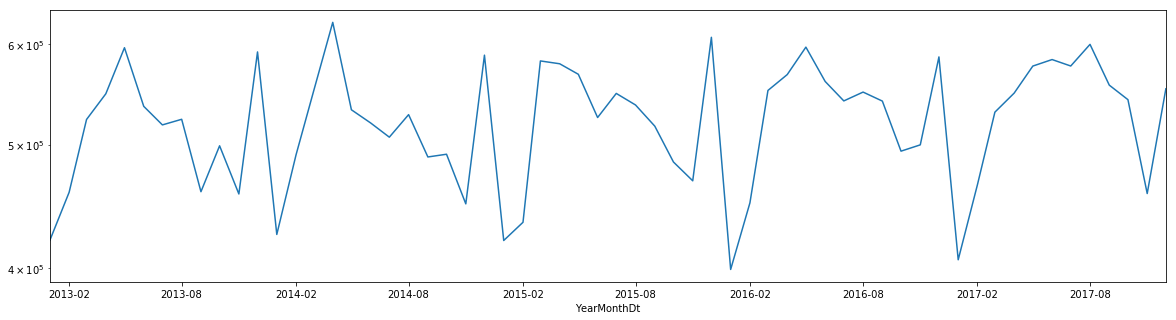

In [23]:
#Time Series of plot
fs['historical_volume'].groupby('YearMonthDt')['Volume'].sum().plot(figsize=(20,5),logy=True)

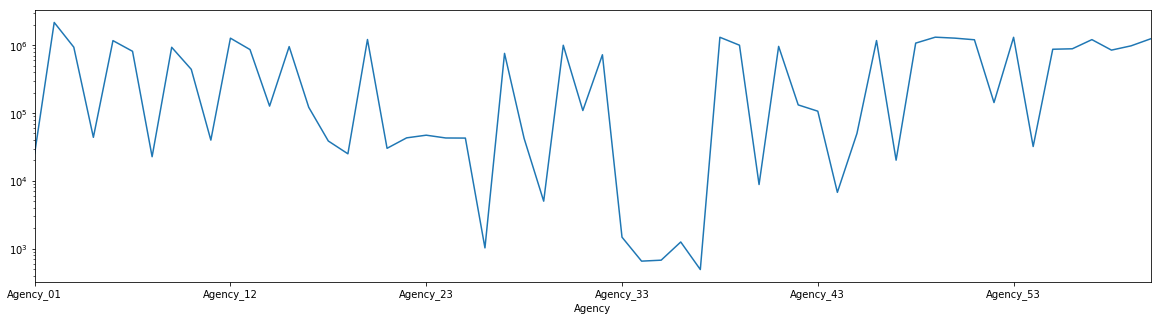

In [24]:
#Sales by Agency
fs['historical_volume'].groupby('Agency')['Volume'].sum().plot(figsize=(20,5),logy=True)

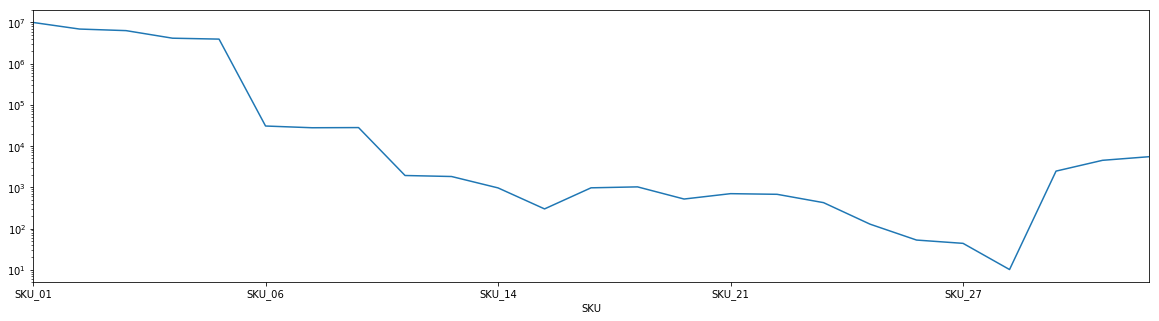

In [25]:
#Sales by Sku
fs['historical_volume'].groupby('SKU')['Volume'].sum().plot(figsize=(20,5),logy=True)

In [66]:
df1=fs['historical_volume'].copy()
df1['Agency']=df1['Agency'].map(lambda x: x[x.find('_')+1:])
df1['SKU']=df1['SKU'].map(lambda x: x[x.find('_')+1:])

for comb in ([['Agency','SKU'],['Agency','YearMonthDt'],['SKU','YearMonthDt']]):
    t1=np.log1p(fs['historical_volume'].groupby(comb)['Volume'].sum()).unstack().fillna(0)
    t1=(t1.T/t1.sum(axis=1)).T
    fig, ax = plt.subplots(figsize=(20,20))
    sns.heatmap(t1, annot=False,ax=ax)
    plt.savefig('02.Profile/01.%s.png'%'_'.join(comb))
    plt.close(fig)

In [201]:
def get_ts_df(df,start,interval,period=1):
    return df1.iloc[:,start-interval-1:start-1:period]

def get_sigs(start_time=60):
    sigs=[]
#     for i in range(1,24):
    for i in [3,4,12]:
        t1=get_ts_df(df1,start_time,i).mean(axis=1).to_frame('avg_volume_ty_p%02dm'%i)
        sigs.append(t1)
        t1=get_ts_df(df1,start_time-12,i).mean(axis=1).to_frame('avg_volume_ly_p%02dm'%i)
        sigs.append(t1)
    for i in [1,2,3]:
        t1=get_ts_df(df1,start_time,12*i,12).mean(axis=1).to_frame('avg_volume_l%dy'%i)
        sigs.append(t1)
    if start_time<61:
        t1=df1.iloc[:,start_time-1].to_frame('tgt')
        sigs.append(t1)
    sigs=pd.concat(sigs,axis=1)
    sigs['month']=start_time
    return sigs.set_index('month',append=True)
    
df1=fs['historical_volume'].set_index(['Agency','SKU','YearMonthKey'])['Volume'].unstack()
master=pd.concat([get_sigs(month) for month in range(36,61)])

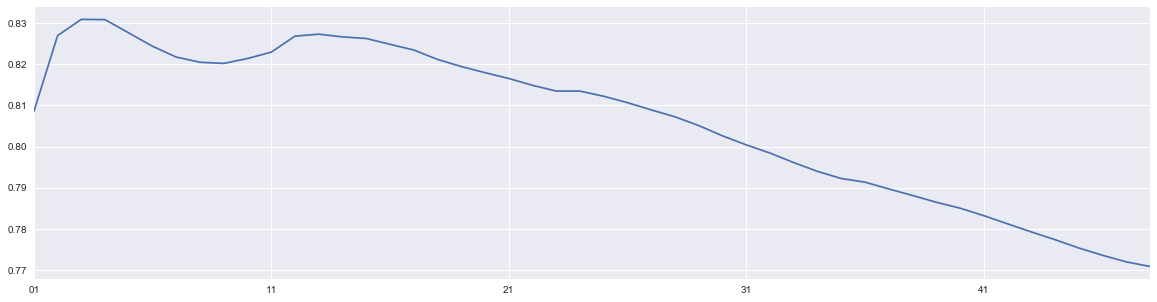

In [115]:
def get_accuracy(col,tgt):
    err=np.abs(col-tgt).sum()
    return 1-err/tgt.sum()

accuracy=[]
for col in master.columns.difference(['tgt']):
    accuracy.append([col[-3:-1],get_accuracy(master[col],master['tgt'])])
pd.Series(dict(accuracy)).plot(figsize=(20,5))

#Last 3,4 months, last 12 months average is able to predict future sales best.
#Use this to find the best exponential parameter

In [202]:
output=[]
for name,group in master.groupby(master.index.get_level_values(2)):
    for col in group.columns.difference(['tgt']):
        output.append([name,col,get_accuracy(group[col],group['tgt'])])
    
pd.DataFrame(output,columns=['month','column','accuracy']).set_index(['month','column'])['accuracy'].unstack().to_clipboard()

In [195]:
#fs['historical_volume'].groupby('YearMonthDt')['Volume'].sum().to_clipboard()
start=61
interval=36
period=12
df1.iloc[:,start-interval-1:start-1:period].columns


Float64Index([25.0, 37.0, 49.0], dtype='float64', name=u'YearMonthKey')

In [207]:
#get_ts_df(df1,37,12,12)

#P3,4,12 Month average this year, last year. Exp average: 3:0.995,4:0.999
#Sales of same month last year. 
#incremental sales ly

In [163]:
#Get exponential factor
def get_sigs_exp(start_time=60):
    sigs=[]
    for i,exp in product([12],[0.997,0.998,0.999,1]):
        wgts=exp**np.arange(i)[::-1]
        t1=(get_ts_df(df1,start_time,i)*wgts).mean(axis=1).to_frame('exp_avg_%0.3f_%d'%(exp,i))
        sigs.append(t1)
    if start_time<61:
        t1=df1.iloc[:,start_time-1].to_frame('tgt')
        sigs.append(t1)
    sigs=pd.concat(sigs,axis=1)
    sigs['month']=start_time
    return sigs.set_index(['month'],append=True)
    
master=pd.concat([get_sigs_exp(month) for month in range(49,61)])

accuracy=[]
for col in master.columns.difference(['tgt']):
    accuracy.append([col,get_accuracy(master[col],master['tgt'])])
pd.Series(dict(accuracy)).sort_values(ascending=False)
# master.head()
#3:0.995
#4:0.999

exp_avg_1.000_12    0.826863
exp_avg_0.999_12    0.826687
exp_avg_0.998_12    0.826394
exp_avg_0.997_12    0.825991
dtype: float64

In [49]:
df2=fs['price_sales_promotion'].set_index(['Agency','SKU','YearMonthKey'])['Sales'].unstack()
df2

YearMonthKey             1.0          2.0          3.0          4.0   \
Agency    SKU                                                          
Agency_01 SKU_01  1033.432731  1065.417195  1101.133633  1138.283357   
          SKU_02   969.186209   996.950762  1061.272227  1113.636725   
          SKU_03  1141.894806  1154.786791  1183.434397  1197.844544   
          SKU_04  1467.681860  1500.037283  1603.699420  1589.691558   
          SKU_05  1172.763381  1171.803584  1243.893486  1242.961649   
          SKU_11  1672.084507  1650.025754  1662.341050  1659.897787   
Agency_02 SKU_01  1033.372521  1073.643772  1085.080036  1139.504837   
          SKU_02   994.178110  1028.759895  1049.897229  1121.235369   
          SKU_03  1129.909681  1162.879613  1184.988902  1205.098245   
          SKU_04  1489.516871  1562.502471  1592.108718  1653.674044   
          SKU_05  1117.887419  1212.239400  1224.581369  1240.008641   
          SKU_11     0.000000     0.000000     0.000000     0.000000   
          SKU_12  1116.270000  1116.270000  1107.952513  1104.030000   
          SKU_31  1101.905085  1101.905085  1112.178433  1122.711864   
          SKU_34  1101.905085  1101.905085  1114.746769  1122.711864   
Agency_03 SKU_01  1084.365140  1106.770181  1133.184926  1182.306371   
          SKU_02  1070.860270  1085.121988  1120.483641  1181.165979   
          SKU_03  1148.075845  1179.435591  1201.191444  1226.964614   
          SKU_04  1554.785937  1653.091783  1679.538951  1691.325470   
          SKU_05  1187.016518  1223.210318  1253.278979  1256.457206   
          SKU_32  1394.347358  1377.217148  1362.373559  1413.913204   
Agency_04 SKU_01  1096.712871  1112.710310  1155.887560  1186.172868   
          SKU_02  1015.718278   963.813284   654.416667  1179.091346   
          SKU_03  1083.973217  1194.976044  1224.332685  1178.022997   
          SKU_04  1427.842395  1675.665361  1728.392336  1639.400985   
          SKU_05   998.544022  1106.133008  1005.541237  1191.836620   
Agency_05 SKU_01  1072.512848  1073.811577  1096.653831  1133.012703   
          SKU_02  1044.056705  1039.679441  1075.769154  1128.183438   
          SKU_03  1190.558102  1185.204172  1220.480303  1250.829103   
          SKU_04  1529.325221  1539.820060  1560.790555  1619.752529   
...                       ...          ...          ...          ...   
Agency_57 SKU_01  1110.166349  1107.460562  1135.154433  1171.045283   
          SKU_02  1114.083097  1110.762556  1135.529249  1170.306241   
          SKU_03  1165.031186  1158.123783  1177.612551  1129.051331   
          SKU_04  1610.704110  1607.928608  1642.886847  1713.793406   
          SKU_05  1203.906029  1201.346415  1223.061120  1298.911127   
          SKU_07  1115.323746  1103.414907  1142.740720  1199.787507   
          SKU_17     0.000000     0.000000     0.000000     0.000000   
          SKU_23     0.000000     0.000000     0.000000     0.000000   
Agency_58 SKU_01  1108.412346  1107.604438  1129.815198  1173.845352   
          SKU_02  1111.244699  1109.894427  1133.762360  1175.792560   
          SKU_03  1164.859673  1152.550517  1208.036876  1163.620702   
          SKU_04  1602.021540  1600.297901  1634.278773  1715.391999   
          SKU_05  1191.462822  1191.290648  1233.170339  1290.358670   
          SKU_07  1098.750254  1092.846966  1127.825493  1190.180516   
          SKU_17     0.000000     0.000000     0.000000     0.000000   
          SKU_23     0.000000     0.000000     0.000000     0.000000   
Agency_59 SKU_01  1134.646428  1139.089487  1165.935173  1202.420383   
          SKU_02  1157.562940  1153.853111  1178.715729  1217.559168   
          SKU_03  1197.184260  1195.390697  1221.402621  1201.869908   
          SKU_04  1473.490236  1537.330104  1584.669171  1663.247597   
          SKU_05  1229.336582  1225.107392  1264.472594  1322.355434   
          SKU_07     0.000000     0.000000     0.000000     0.000000   
          SKU_17     0.000000     0.0000

In [53]:
df1=pd.merge(fs['historical_volume'],fs['price_sales_promotion'],on=['Agency','SKU','YearMonth','YearMonthKey','YearMonthDt'])
df1.to_clipboard()

In [210]:
a=pd.read_csv('01.RawData/historical_volume.csv')
b=pd.read_csv('01.RawData/price_sales_promotion.csv')
pd.merge(a,b,on=['Agency','SKU','YearMonth']).to_csv('01.RawData/volume_master.csv')